Author: Joel Konrad Minj

Core Design: Activity 4

Using OpenMC 0.15.1 and Python 3.13.2

In [1]:
import glob
from math import log10, sqrt, pi
import matplotlib.pyplot as plt
import numpy as np
import openmc
import os
import logging
import pandas as pd

from openmc import config
config['cross_sections'] = r'/home/joelminj/OpenMC/endfb-vii.1-hdf5/cross_sections.xml'

In [2]:
model = openmc.Model()

Remove past files

In [ ]:
def safe_remove(file_path):
    try:
        os.remove(file_path)
        logging.info(f"Removed file: {file_path}")
    except FileNotFoundError:
        logging.warning(f"File not found: {file_path}")
    except Exception as e:
        logging.error(f"Error removing file {file_path}: {e}")

# Remove past files
files_to_remove = [
    'materials.xml', 'geometry.xml', 'tallies.xml', 'summary.h5',
    'statepoint.50.h5', 'plots.xml', 'tallies.out', 'statepoint.1000.h5',
    'statepoint.10000.h5', 'settings.xml', 'fuel_assembly.xml', 'model.xml'
]

for file in files_to_remove:
    safe_remove(file)

Parameters

In [4]:
# Constants
fuel_rod_pitch = 1.26  # cm
assembly_width = 17 * fuel_rod_pitch
assembly_height = 365.8  # cm
fuel_rod_outer_radius = 9.5/20 # cm
fuel_rod_inner_radius = 8.36/20 # cm
cladding_thickness = 0.57/10 # cm
fuel_pellet_radius = 8.19/20 # cm
guide_tube_inner_radius = 11.05/20  # cm
guide_tube_outer_radius = 12.09/20 # cm
instrument_tube_inner_radius = 11.428/20 # cm
instrument_tube_outer_radius = 12.24/20 # cm

Materials

In [ ]:
# Material Definitions
mod_temp = 586.325
fuel_temp = 900
enrichment = 3
densF = 10.0701
densM = openmc.data.water_density(mod_temp, 15.5)

M_U = openmc.data.atomic_weight('U')
M_O = openmc.data.atomic_weight('O')
M_H = openmc.data.atomic_weight('H')
M_Gd = openmc.data.atomic_weight('Gd')
M_UO2 = M_U + 2 * M_O
M_H2O = 2 * M_H + M_O
M_Gd2O3 = 2 * M_Gd + 3 * M_O

# Fractions of weight of the materials: Fuel (F), Moderator (M)
wF_U = M_U / M_UO2
wF_O = (2 * M_O) / M_UO2
wM_H = (2 * M_H) / M_H2O
wM_O = M_O / M_H2O

# Materials
fuel = openmc.Material(name='UO2')
fuel.add_element('U', 1.0, enrichment=enrichment)
fuel.add_element('O', 2.0)
fuel.set_density('g/cm3', densF)

moderator = openmc.Material(name='Water')
moderator.add_element('H', wM_H, 'wo')
moderator.add_element('O', wM_O, 'wo')
moderator.set_density('g/cm3', densM)
moderator.add_s_alpha_beta('c_H_in_H2O')

zircaloy = openmc.Material(name='Zircaloy-4')
zircaloy.set_density('g/cm3', 5.8213)
zircaloy.add_element('Zr', 0.99689)
zircaloy.add_element('Fe', 0.0021067)
zircaloy.add_element('Cr', 0.0010033)
zircaloy.add_element('Sn', 0.0009967)
zircaloy.add_element('O', 0.00000001)

# Poison Material
eGdO = 0.095
eGd154 = 0.0218
eGd155 = 0.148
eGd156 = 0.2047
eGd157 = 0.1565
eGd158 = 0.2484
eGd160 = 0.2186

fuel_poison = openmc.Material(name='UO2+Gd2O3')
fuel_poison.set_density('g/cm3', densF)
fuel_poison.add_element('U', (1-eGdO), enrichment=enrichment)
fuel_poison.add_element('O', 2*(1-eGdO))
fuel_poison.add_nuclide('Gd154', eGdO * eGd154 * openmc.data.atomic_mass('Gd154') / M_Gd2O3)
fuel_poison.add_nuclide('Gd155', eGdO * eGd155 * openmc.data.atomic_mass('Gd155') / M_Gd2O3)
fuel_poison.add_nuclide('Gd156', eGdO * eGd156 * openmc.data.atomic_mass('Gd156') / M_Gd2O3)
fuel_poison.add_nuclide('Gd157', eGdO * eGd157 * openmc.data.atomic_mass('Gd157') / M_Gd2O3)
fuel_poison.add_nuclide('Gd158', eGdO * eGd158 * openmc.data.atomic_mass('Gd158') / M_Gd2O3)
fuel_poison.add_nuclide('Gd160', eGdO * eGd160 * openmc.data.atomic_mass('Gd160') / M_Gd2O3)
fuel_poison.add_element('O', 3*eGdO)


agincd = openmc.Material(name='AgInCd')
agincd.add_element('Ag', 0.80)
agincd.add_element('In', 0.15)
agincd.add_element('Cd', 0.05)
agincd.set_density('g/cm3', 10.17)


colors = {
	moderator: 'lightblue',
	zircaloy: 'gray',
	fuel: 'red'
}


Geometry

In [6]:
fuel_outer_radius = openmc.ZCylinder(r=fuel_pellet_radius)
clad_outer_radius = openmc.ZCylinder(r=fuel_rod_outer_radius)

# Universe Definitions
fuel_pin_universe = openmc.Universe(name='Fuel Pin')
fuel_cell = openmc.Cell(name='Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
fuel_pin_universe.add_cell(fuel_cell)

clad_cell = openmc.Cell(name='Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_universe.add_cell(clad_cell)

moderator_cell = openmc.Cell(name='Moderator')
moderator_cell.fill = moderator
moderator_cell.region = +clad_outer_radius
fuel_pin_universe.add_cell(moderator_cell)

# Fuel Pin with Burnable poison
fuel_pin_poison_universe = openmc.Universe(name='Fuel Pin Poison')
fuel_poison_cell = openmc.Cell(name='Fuel Poison')
fuel_poison_cell.fill = fuel_poison
fuel_poison_cell.region = -fuel_outer_radius
fuel_pin_poison_universe.add_cell(fuel_poison_cell)

clad_poison_cell = openmc.Cell(name='Clad Poison')
clad_poison_cell.fill = zircaloy
clad_poison_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_poison_universe.add_cell(clad_poison_cell)

moderator_poison_cell = openmc.Cell(name='Moderator Poison')
moderator_poison_cell.fill = moderator
moderator_poison_cell.region = +clad_outer_radius
fuel_pin_poison_universe.add_cell(moderator_poison_cell)

guide_tube_universe = openmc.Universe(name='Guide Tube')
guide_tube_cell = openmc.Cell(name='Guide Tube Water')
guide_tube_cell.fill = moderator
guide_tube_cell.region = -fuel_outer_radius
guide_tube_universe.add_cell(guide_tube_cell)

clad_guide_cell = openmc.Cell(name='Guide Clad')
clad_guide_cell.fill = zircaloy
clad_guide_cell.region = +fuel_outer_radius & -clad_outer_radius
guide_tube_universe.add_cell(clad_guide_cell)

moderator_guide_cell = openmc.Cell(name='Guide Tube Moderator')
moderator_guide_cell.fill = moderator
moderator_guide_cell.region = +clad_outer_radius
guide_tube_universe.add_cell(moderator_guide_cell)

# Control Rod
control_rod_pin_universe = openmc.Universe(name='Control Rod Pin')
control_rod_cell = openmc.Cell(name='Control Rod')
control_rod_cell.fill = agincd
control_rod_cell.region = -fuel_outer_radius
control_rod_pin_universe.add_cell(control_rod_cell)

clad_control_cell = openmc.Cell(name='Clad Control Rod')
clad_control_cell.fill = zircaloy
clad_control_cell.region = +fuel_outer_radius & -clad_outer_radius
control_rod_pin_universe.add_cell(clad_control_cell)

moderator_control_cell = openmc.Cell(name='Moderator Control Rod')
moderator_control_cell.fill = moderator
moderator_control_cell.region = +clad_outer_radius
control_rod_pin_universe.add_cell(moderator_control_cell)

instrument_tube_universe = openmc.Universe(name='Instrument Tube')
instrument_tube_outer_cylinder = openmc.ZCylinder(r=instrument_tube_outer_radius)
instrument_tube_inner_cylinder = openmc.ZCylinder(r=instrument_tube_inner_radius)

instrument_tube_moderator_cell = openmc.Cell(name='Instrument Tube Moderator')
instrument_tube_moderator_cell.fill = moderator
instrument_tube_moderator_cell.region = -instrument_tube_inner_cylinder
instrument_tube_universe.add_cell(instrument_tube_moderator_cell)

instrument_tube_clad_cell = openmc.Cell(name='Instrument Tube Clad')
instrument_tube_clad_cell.fill = zircaloy
instrument_tube_clad_cell.region = +instrument_tube_inner_cylinder & -instrument_tube_outer_cylinder
instrument_tube_universe.add_cell(instrument_tube_clad_cell)

instrument_tube_outer_moderator_cell = openmc.Cell(name='Instrument Tube Outer Moderator')
instrument_tube_outer_moderator_cell.fill = moderator
instrument_tube_outer_moderator_cell.region = +instrument_tube_outer_cylinder
instrument_tube_universe.add_cell(instrument_tube_outer_moderator_cell)

# Base Lattice Definition
guide_tube_positions = [(2, 5), (2, 8), (2, 11),
                        (5, 2), (5, 5), (5, 8), (5, 11), (5, 14),
                        (8, 2), (8, 5), (8, 11), (8, 14),
                        (11, 2), (11, 5), (11, 8), (11, 11), (11, 14),
                        (14, 5), (14, 8), (14, 11)]
instrument_tube_position = (8, 8)
burnable_poison_positions = [(3, 3), (3, 13), (13, 3), (13, 13)]

Common settings

In [7]:
batches = 5000
inactive = 200
particles = 1000
#settings.output = {'tallies': False}

Assembly plot

In [8]:
# Plot Definition
plot = openmc.Plot()
plot.filename = 'fuel_assembly'
plot.width = [assembly_width, assembly_width]
plot.pixels = [500, 500]
plot.color_by = 'material'
plot.origin = [0, 0, 0]
plot.basis = 'xy'

Function Cases

In [ ]:
def create_and_run(case_name, control_rods_inserted, use_burnable_poison):
    print(f"Running case: {case_name}")
    # Geometry Definition

    # Moderator surrounding lattice of cells
    moderator_cell = openmc.Cell(fill=moderator)
    all_water = openmc.Universe(name='all_water', cells=[moderator_cell])

    # fuel assembly Lattice
    assembly = openmc.RectLattice(name='Fuel Assembly')
    assembly.pitch = (fuel_rod_pitch, fuel_rod_pitch)
    assembly.lower_left = [-assembly_width / 2] * 2
    assembly.outer = all_water

    # Empty 17x17 array of the lattice universes
    universes = np.empty((17, 17), dtype=openmc.Universe)
    # Fill the array with the fuel pin universes
    universes[:, :] = fuel_pin_universe

    for row, col in guide_tube_positions:
        universes[row, col] = guide_tube_universe

    
    if use_burnable_poison:
        for row, col in burnable_poison_positions:
            universes[row, col] = fuel_pin_poison_universe

    row, col = instrument_tube_position
    universes[row, col] = instrument_tube_universe

    # Insert or remove control Rods
    if control_rods_inserted:
        for row, col in guide_tube_positions:
            universes[row, col] = control_rod_pin_universe

    assembly.universes = universes
    # boundary conditions

    min_x_root = openmc.XPlane(x0=-assembly_width/2, boundary_type='reflective')
    max_x_root = openmc.XPlane(x0=+assembly_width/2, boundary_type='reflective')
    min_y_root = openmc.YPlane(y0=-assembly_width/2, boundary_type='reflective')
    max_y_root = openmc.YPlane(y0=+assembly_width/2, boundary_type='reflective')
    min_z_root = openmc.ZPlane(z0=-assembly_height / 2, boundary_type='reflective')
    max_z_root = openmc.ZPlane(z0=+assembly_height / 2, boundary_type='reflective')

    root_region = +min_x_root & -max_x_root & +min_y_root & -max_y_root & +min_z_root & -max_z_root
    root_cell = openmc.Cell(name='Root Cell', fill=assembly, region=root_region)
    root_universe = openmc.Universe(name='Root Universe')
    root_universe.add_cell(root_cell)
    geometry = openmc.Geometry(root_universe)

    # Settings Definition
    settings = openmc.Settings()
    settings.batches = batches
    settings.inactive = inactive
    settings.particles = particles
    settings.temperature = {'method': 'interpolation'}
    #settings.output = {'tallies': False}

    bounds = [-assembly_width/2, -assembly_width/2, -assembly_height/2,
              assembly_width/2, assembly_width/2, assembly_height/2]
    uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
    settings.source = openmc.Source(space=uniform_dist)

    # Tally Definition
    tallies = openmc.Tallies()

    # Mesh tally to get flux distribution
    mesh = openmc.RegularMesh(name='assembly_mesh')
    mesh.dimension = [170, 170, 1]  
    mesh.lower_left = [-assembly_width/2, -assembly_width/2, -assembly_height/2]
    mesh.upper_right = [assembly_width/2, assembly_width/2, assembly_height/2]
    mesh_filter = openmc.MeshFilter(mesh)


    # flux tally
    flux_tally = openmc.Tally(name="assembly_flux")
    flux_tally.filters = [mesh_filter]
    flux_tally.scores = ["flux"]
    tallies.append(flux_tally)
    
    # fission rate tally
    fission_rate_tally = openmc.Tally(name="fission_rate")
    fission_rate_tally.filters = [mesh_filter]
    fission_rate_tally.scores = ["fission"]
    tallies.append(fission_rate_tally)
    
    tallies = openmc.Tallies([flux_tally, fission_rate_tally])
    
    tallies.export_to_xml()
    
    # Run OpenMC model
    model = openmc.Model(geometry=geometry, materials=openmc.Materials([fuel, moderator, zircaloy, fuel_poison, agincd]), settings=settings, tallies=tallies)
    model.run()
    
    # saving plots
    plot = openmc.Plot()
    plot.filename = f'{case_name}_assembly'
    plot.width = [assembly_width, assembly_width]
    plot.pixels = [500, 500]
    plot.color_by = 'material'
    plot.origin = [0, 0, 0]
    plot.basis = 'xy'

    plots = openmc.Plots([plot])
    plots.export_to_xml()
    openmc.plot_geometry()
    img = plt.imread(f'{case_name}_assembly.png')
    plt.imshow(img, origin='lower')

    # Extract and Plot Flux
    statepoint = openmc.StatePoint('statepoint.5000.h5')
    flux_tally = statepoint.get_tally(name='assembly_flux')
    flux_values = flux_tally.mean.reshape((170, 170))


    # Plotting flux distribution
    plt.figure(figsize=(8, 8))
    plt.imshow(flux_values, extent=[-assembly_width/2, assembly_width/2, -assembly_width/2, assembly_width/2], origin='lower', cmap='jet')
    plt.colorbar(label='Neutron Flux')
    plt.title(f'Neutron Flux Distribution - {case_name}')
    plt.xlabel('X Position (cm)')
    plt.ylabel('Y Position (cm)')
    flux_image_path = f'{case_name}_flux.png'
    plt.savefig(flux_image_path)  # Save the figure
    plt.close()

    # Extract and Plot Fission Rate
    fission_rate_tally = statepoint.get_tally(name='fission_rate')
    fission_rates = fission_rate_tally.mean.reshape((170, 170))
    plt.figure(figsize=(8, 8))
    extent = [-assembly_width/2, assembly_width/2, -assembly_width/2, assembly_width/2]
    plt.imshow(fission_rates, interpolation='none', cmap='jet', extent=extent, origin='lower')
    plt.colorbar(label='Fission Rate')
    plt.title(f'Fission Rate Distribution in Assembly - {case_name}')
    plt.xlabel('X Position (cm)')
    plt.ylabel('Y Position (cm)')
    plt.grid(False)
    plt.tight_layout()
    fission_image_path = f'{case_name}_fission_rate.png'
    plt.savefig(fission_image_path)  # Save the figure
    plt.close()

    return plt.imread(flux_image_path), plt.imread(fission_image_path)



Main Script

/home/joelminj/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/stats/multivariate.py:829: FutureWarning: The 'only_fissionable' has been deprecated. Use the 'constraints' argument when defining a source instead.
  warn("The 'only_fissionable' has been deprecated. Use the "
/home/joelminj/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/source.py:656: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


Running case: Case 1
[studiojkm:79864] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.studiojkm.1000/jf.0/2478964736/shared_mem_cuda_pool.studiojkm could be created.
[studiojkm:79864] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%

/home/joelminj/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/stats/multivariate.py:829: FutureWarning: The 'only_fissionable' has been deprecated. Use the 'constraints' argument when defining a source instead.
  warn("The 'only_fissionable' has been deprecated. Use the "
/home/joelminj/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/source.py:656: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


[studiojkm:80389] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.studiojkm.1000/jf.0/3889954816/shared_mem_cuda_pool.studiojkm could be created.
[studiojkm:80389] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
      

/home/joelminj/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/stats/multivariate.py:829: FutureWarning: The 'only_fissionable' has been deprecated. Use the 'constraints' argument when defining a source instead.
  warn("The 'only_fissionable' has been deprecated. Use the "
/home/joelminj/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/source.py:656: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


[studiojkm:80879] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.studiojkm.1000/jf.0/3999006720/shared_mem_cuda_pool.studiojkm could be created.
[studiojkm:80879] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
      

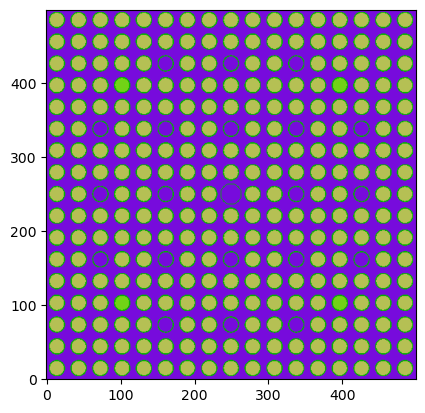

In [10]:
for case_name in ['Case 1', 'Case 2', 'Case 3']:
    safe_remove(f'{case_name}_assembly.png')
    safe_remove(f'{case_name}_flux.png')
    safe_remove(f'{case_name}_fission_rate.png') 

# Case 1: control bars withdrawn, no burnable poison
case1_flux_img, case1_fission_img = create_and_run("Case 1", control_rods_inserted=False, use_burnable_poison=False)
# Case 2: control bars fully inserted, no burnable poison
case2_flux_img, case2_fission_img = create_and_run("Case 2", control_rods_inserted=True, use_burnable_poison=False)
# Case 3: control bars withdrawn, yes burnable poison
case3_flux_img, case3_fission_img = create_and_run("Case 3", control_rods_inserted=False, use_burnable_poison=True)

Plot Comparison

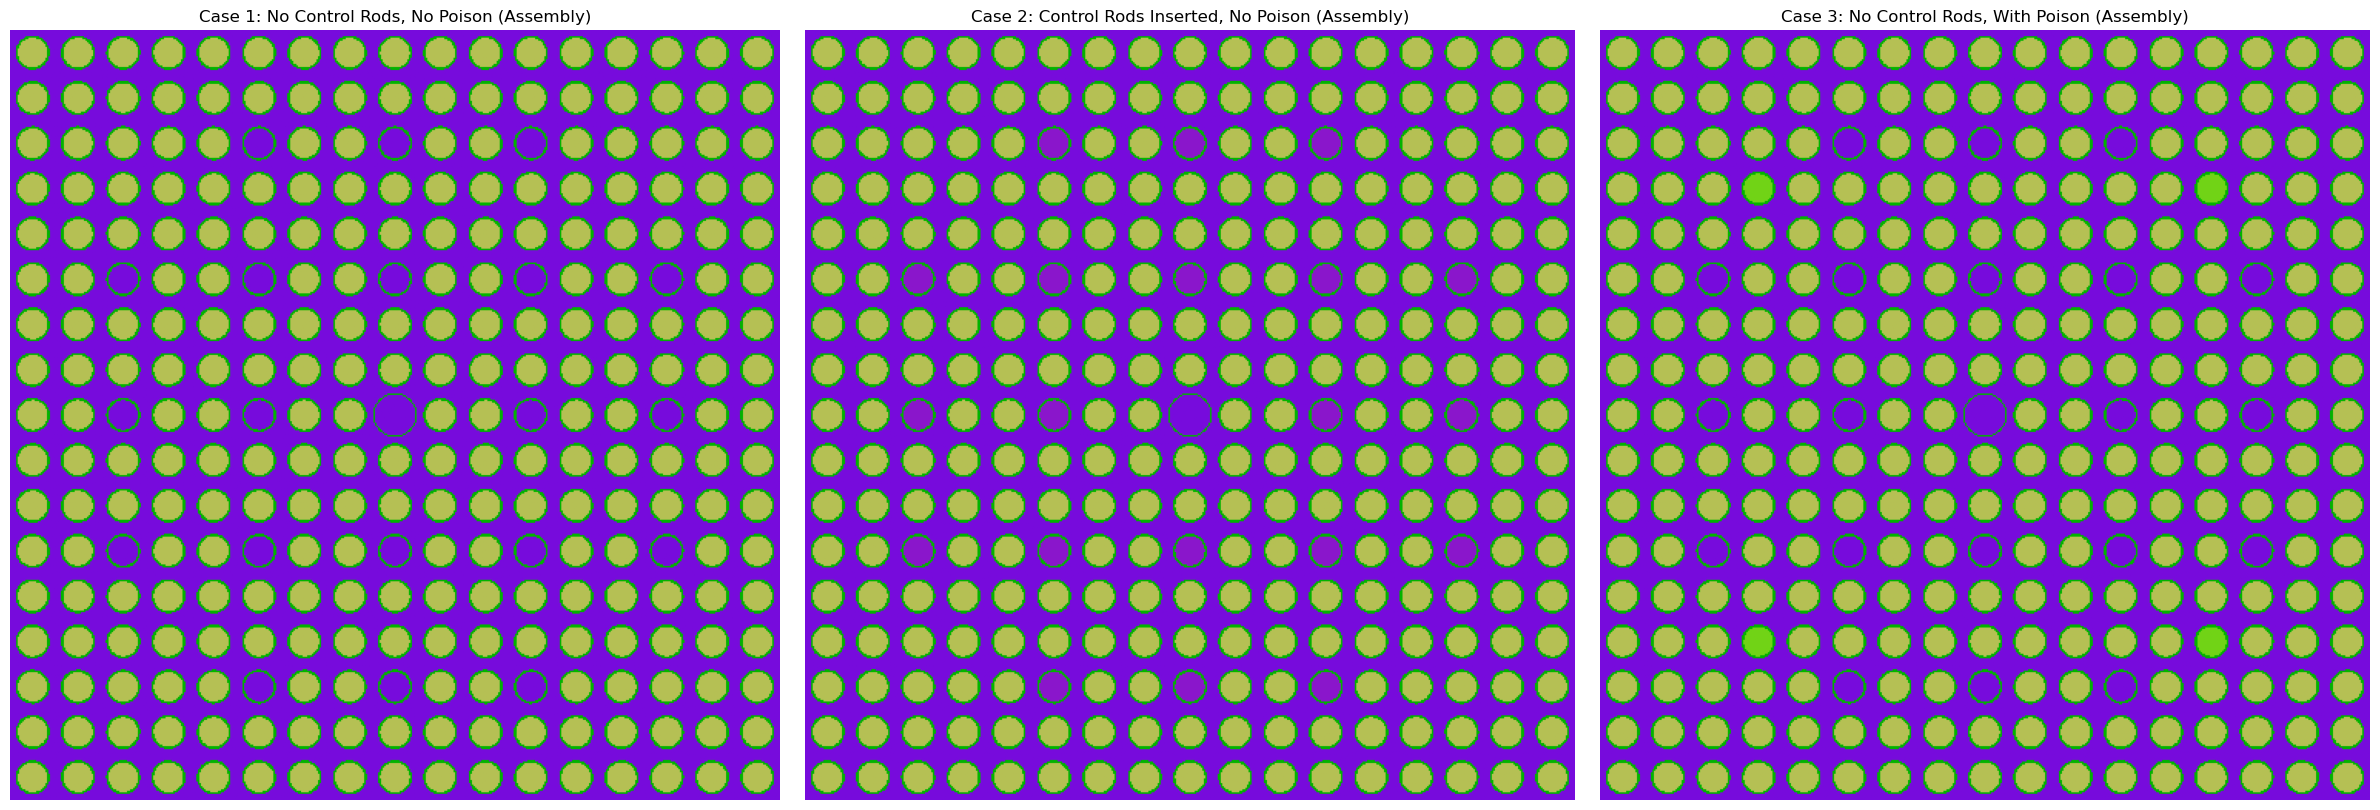

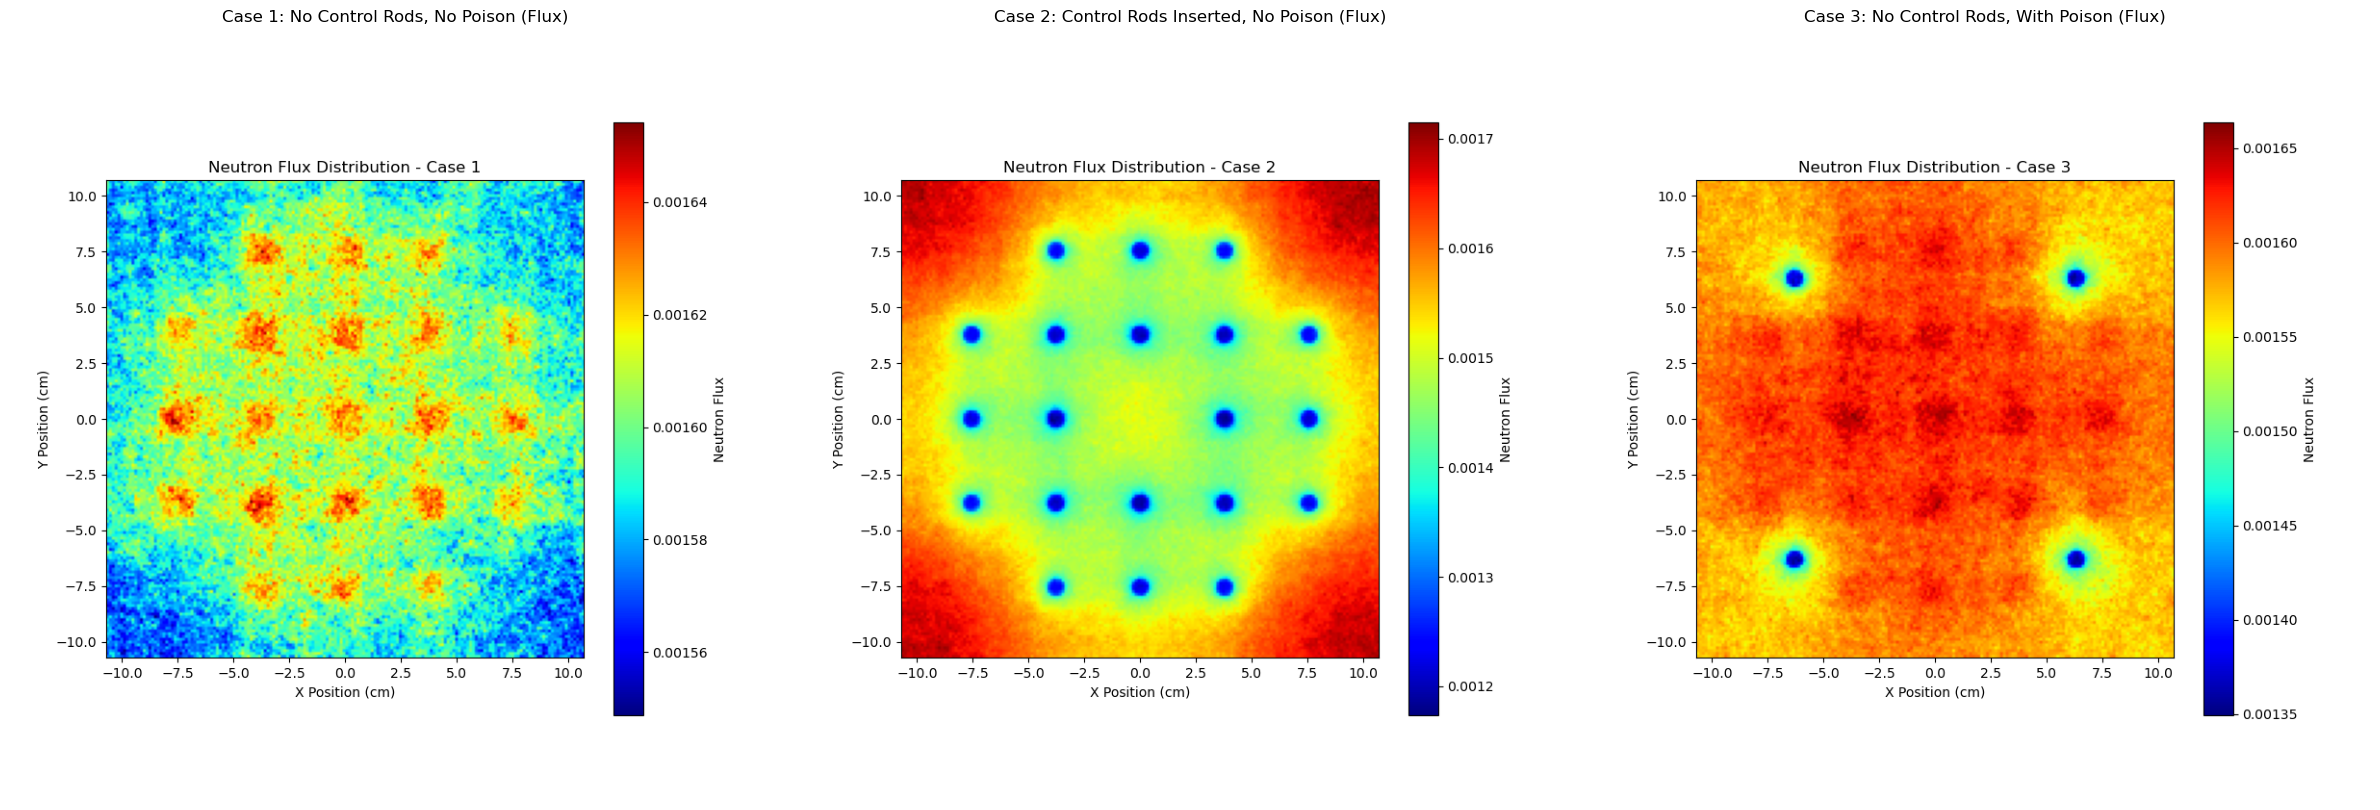

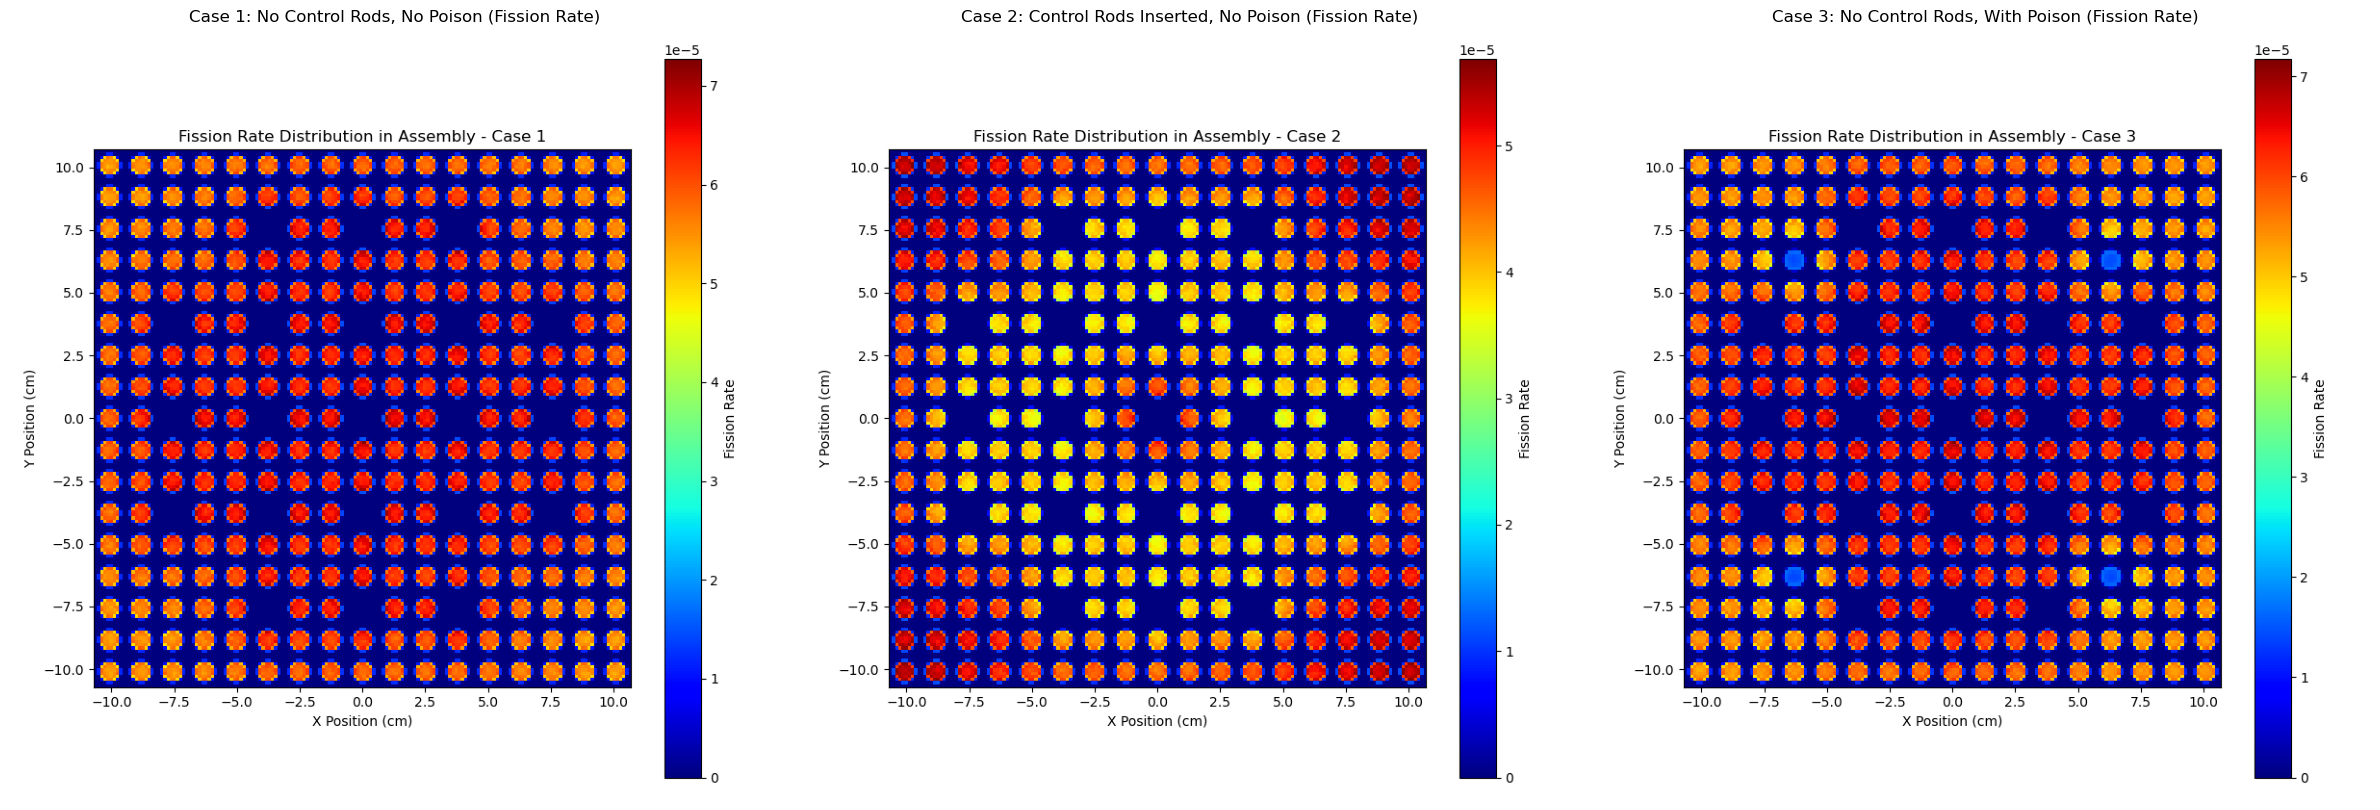

                                       Case     k-eff  Normalized k-eff
0        Case 1: No Control Rods, No Poison  1.313165               1.0
1  Case 2: Control Rods Inserted, No Poison  1.313165               1.0
2      Case 3: No Control Rods, With Poison  1.313165               1.0


In [ ]:
# 1x3 grid for assembly plots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns

# Assembly Plots
case1_assembly_img = plt.imread('Case 1_assembly.png')
case2_assembly_img = plt.imread('Case 2_assembly.png')
case3_assembly_img = plt.imread('Case 3_assembly.png')

axes[0].imshow(case1_assembly_img)
axes[0].set_title('Case 1: No Control Rods, No Poison (Assembly)')
axes[0].axis('off')

axes[1].imshow(case2_assembly_img)
axes[1].set_title('Case 2: Control Rods Inserted, No Poison (Assembly)')
axes[1].axis('off')

axes[2].imshow(case3_assembly_img)
axes[2].set_title('Case 3: No Control Rods, With Poison (Assembly)')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('assembly_comparison.png')
plt.show()


# 1x3 grid for neutron flux plots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns

case1_img = plt.imread('Case 1_flux.png')
case2_img = plt.imread('Case 2_flux.png')
case3_img = plt.imread('Case 3_flux.png')

# Neutron Flux Plots
axes[0].imshow(case1_img)
axes[0].set_title('Case 1: No Control Rods, No Poison (Flux)')
axes[0].axis('off')

axes[1].imshow(case2_img)
axes[1].set_title('Case 2: Control Rods Inserted, No Poison (Flux)')
axes[1].axis('off')

axes[2].imshow(case3_img)
axes[2].set_title('Case 3: No Control Rods, With Poison (Flux)')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('flux_comparison.png')
plt.show()

# 1x3 grid for fission rate plots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns

# Fission Rate Plots
case1_fission_img = plt.imread('Case 1_fission_rate.png')
case2_fission_img = plt.imread('Case 2_fission_rate.png')
case3_fission_img = plt.imread('Case 3_fission_rate.png')

axes[0].imshow(case1_fission_img)
axes[0].set_title('Case 1: No Control Rods, No Poison (Fission Rate)')
axes[0].axis('off')

axes[1].imshow(case2_fission_img)
axes[1].set_title('Case 2: Control Rods Inserted, No Poison (Fission Rate)')
axes[1].axis('off')

axes[2].imshow(case3_fission_img)
axes[2].set_title('Case 3: No Control Rods, With Poison (Fission Rate)')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('fission_rate_comparison.png')
plt.show()

statepoint_files = ['statepoint.5000.h5', 'statepoint.5000.h5', 'statepoint.5000.h5']  # Replace with actual statepoint files for each case
k_eff_values = []

for statepoint_file in statepoint_files:
    sp = openmc.StatePoint(statepoint_file)
    k_eff = sp.keff.nominal_value  # Extract k-effective nominal value
    k_eff_values.append(k_eff)
    
# Normalize k-eff values
k_eff_normalized = [value / max(k_eff_values) for value in k_eff_values]


data = {
    "Case": [
        "Case 1: No Control Rods, No Poison",
        "Case 2: Control Rods Inserted, No Poison",
        "Case 3: No Control Rods, With Poison",
    ],
    "k-eff": k_eff_values,
    "Normalized k-eff": k_eff_normalized,
}

df = pd.DataFrame(data)

print(df)

